## Exploratory analysis of the MM-WHS dataset

In [83]:
# imports 
import numpy as np
import os
import monai
from monai.data import CacheDataset, DataLoader, GridPatchDataset
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
    MapLabelValued,
    LoadImage,
    SpatialPadd,
)

import matplotlib.pyplot as plt
import glob
import torch
import SimpleITK as sitk
import random

# Example MR dataset

In [102]:
data_dir = "../MMWHS_Dataset/mr_train"
images = sorted(glob.glob(os.path.join(data_dir, "mr_train_1003_image.nii.gz")))
labels = sorted(glob.glob(os.path.join(data_dir, "mr_train_1003_label.nii.gz")))

example_dataset = [{"img": img, "seg": seg} for img, seg in zip(images, labels)]
print(len(example_dataset))

1


In [103]:
all_images = sorted(glob.glob(os.path.join(data_dir, "mr_train_*_image.nii.gz")))
random.shuffle(all_images)
train_images = all_images[:16]
len(train_images)
val_images = all_images[16:18]
len(val_images)
test_images = all_images[18:]
len(test_images)
print(train_images)
print(val_images)
print(test_images)

['../MMWHS_Dataset/mr_train/mr_train_1001_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1014_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1003_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1006_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1012_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1020_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1005_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1017_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1018_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1002_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1019_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1010_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1016_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1009_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1015_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1011_image.nii.gz']
['../MMWHS_Dataset/mr_train/mr_train_1008_image.nii.gz', '../MMWHS_Dataset/mr_train/mr_train_1013_image

In [104]:
volume_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        EnsureChannelFirstd(keys=["img", "seg"]),
        ScaleIntensityd(keys="img"), # normalization between 0 and 1
        EnsureTyped(keys=["img", "seg"]),
    ]
)

In [105]:
volume_ds_person1 = CacheDataset(data=example_dataset, transform=volume_transforms, cache_rate=1.0, num_workers=4) # experiment with last two parameters
check_loader = DataLoader(volume_ds_person1, batch_size=1)
check_data = monai.utils.misc.first(check_loader)

Loading dataset: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


In [106]:
print("first volume's shape", check_data["img"].shape, check_data["seg"].shape)

middle_image = check_data["img"][0, :, :, :, 70]
middle_label = check_data["seg"][0, :, :, :, 70]
print("image shape", middle_image.shape, "label shape", middle_label.shape)

first volume's shape torch.Size([1, 1, 288, 288, 160]) torch.Size([1, 1, 288, 288, 160])
image shape torch.Size([1, 288, 288]) label shape torch.Size([1, 288, 288])


In [107]:
patch_func = monai.data.PatchIterd(
    keys=["img", "seg"],
    patch_size=(None, 1, None),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)
patch_transform = Compose(
    [
        SqueezeDimd(keys=["img", "seg"], dim=0),  # squeeze the last dim
        #Resized(keys=["img", "seg"], spatial_size=[512, 1, 512]),
        SpatialPadd(keys=["img", "seg"], spatial_size=[512, 512], mode="zeros"),
        MapLabelValued(keys=["seg"], orig_labels=[205, 420, 500, 550, 600, 820, 850], target_labels=[1, 2, 3, 4, 5 , 6 , 7]),
    ]
)

example_patch_ds = GridPatchDataset(data=volume_ds_person1, patch_iter=patch_func, transform=patch_transform)
patch_data_loader = DataLoader(example_patch_ds, batch_size=1, num_workers=2, pin_memory=torch.cuda.is_available())


In [108]:
for batch in patch_data_loader:
    image, label = batch[0]["img"], batch[0]["seg"]
    print("image shape", image.shape, "label shape", label.shape)
    slice_image = sitk.GetImageFromArray(image)
    slice_label = sitk.GetImageFromArray(label)
    print("image shape", slice_image.GetSize(), "label shape", slice_label.GetSize())
    break

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/croppad/functional.py", line 106, in pad_nd
    return _pad(img, pad_width=to_pad, mode=mode, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/croppad/functional.py", line 52, in _np_pad
    mode = convert_pad_mode(dst=img_np, mode=mode).value
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/utils.py", line 1729, in convert_pad_mode
    return look_up_option(mode, NumpyPadMode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/utils/module.py", line 143, in look_up_option
    raise ValueError(f"Unsupported option '{opt_str}', " + supported_msg)
ValueError: Unsupported option 'zeros', Available options are {'mean', 'reflect', 'constant', 'wrap', 'minimum', 'empty', 'symmetric', 'edge', 'median', 'linear_ramp', 'maximum'}.


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/croppad/dictionary.py", line 168, in __call__
    d[key] = self.padder(d[key], mode=m, lazy=lazy_)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/croppad/array.py", line 168, in __call__
    return pad_func(img_t, to_pad_, self.get_transform_info(), mode_, lazy_, **kwargs_)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/croppad/functional.py", line 208, in pad_func
    out = pad_nd(out, to_pad_list, mode, **kwargs) if do_pad else out
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/croppad/functional.py", line 111, in pad_nd
    return _np_pad(img, pad_width=to_pad, mode=mode, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/croppad/functional.py", line 52, in _np_pad
    mode = convert_pad_mode(dst=img_np, mode=mode).value
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/utils.py", line 1729, in convert_pad_mode
    return look_up_option(mode, NumpyPadMode)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/utils/module.py", line 143, in look_up_option
    raise ValueError(f"Unsupported option '{opt_str}', " + supported_msg)
ValueError: Unsupported option 'zeros', Available options are {'mean', 'reflect', 'constant', 'wrap', 'minimum', 'empty', 'symmetric', 'edge', 'median', 'linear_ramp', 'maximum'}.


The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 32, in fetch
    data.append(next(self.dataset_iter))
                ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/data/grid_dataset.py", line 363, in __iter__
    yield from self._generate_patches(self.patch_iter(image))
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/data/grid_dataset.py", line 333, in _generate_patches
    out_patch = self.patch_transform(patch, **apply_args)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/compose.py", line 335, in __call__
    result = execute_compose(
             ^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/compose.py", line 111, in execute_compose
    data = apply_transform(
           ^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.croppad.dictionary.SpatialPadd object at 0x15537d750b90>


In [85]:
i = 0
current_directory = os.getcwd()
output_dir_image = "preprocessed/mr_examples/images"
output_dir_label = "preprocessed/mr_examples/labels"

os.makedirs(output_dir_image, exist_ok=True)
os.makedirs(output_dir_label, exist_ok=True)
j = 0
for batch in patch_data_loader:
    image, label = batch[0]["img"], batch[0]["seg"]
    j += 1
    #print("image shape", image.shape, "label shape", label.shape)
    
    if torch.any(label.data != 0).item():
        image = image.squeeze(2)
        label = label.squeeze(2)
        print(image.shape)
        print(label.shape)
        # Convert the torch tensor to a SimpleITK image
        slice_image = sitk.GetImageFromArray(image)
        slice_label = sitk.GetImageFromArray(label)
        # # Save the 2D slice as a NIfTI file
        sitk.WriteImage(slice_image, os.path.join(output_dir_image, f"new_slice_axial_pad.nii.gz"))
        sitk.WriteImage(slice_label, os.path.join(output_dir_label, f"new_slice_axial_pad.nii.gz"))
        i += 1
        #if i == 20:
        break

print("Total number of slices:", j)

    

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/transform.py", line 141, in apply_transform
    return _apply_transform(transform, data, unpack_items, lazy, overrides, log_stats)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/transform.py", line 98, in _apply_transform
    return transform(data, lazy=lazy) if isinstance(transform, LazyTrait) else transform(data)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/croppad/dictionary.py", line 168, in __call__
    d[key] = self.padder(d[key], mode=m, lazy=lazy_)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/croppad/array.py", line 161, in __call__
    to_pad_ = self.compute_pad_width(spatial_shape)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/croppad/array.py", line 231, in compute_pad_width
    spatial_size = fall_back_tuple(self.spatial_size, spatial_shape)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/utils/misc.py", line 279, in fall_back_tuple
    user = ensure_tuple_rep(user_provided, ndim)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/utils/misc.py", line 205, in ensure_tuple_rep
    raise ValueError(f"Sequence must have length {dim}, got {len(tup)}.")
ValueError: Sequence must have length 2, got 3.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 32, in fetch
    data.append(next(self.dataset_iter))
                ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/data/grid_dataset.py", line 363, in __iter__
    yield from self._generate_patches(self.patch_iter(image))
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/data/grid_dataset.py", line 333, in _generate_patches
    out_patch = self.patch_transform(patch, **apply_args)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/compose.py", line 335, in __call__
    result = execute_compose(
             ^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/compose.py", line 111, in execute_compose
    data = apply_transform(
           ^^^^^^^^^^^^^^^^
  File "/home/aeijpe/.conda/envs/gpu_env/lib/python3.11/site-packages/monai/transforms/transform.py", line 171, in apply_transform
    raise RuntimeError(f"applying transform {transform}") from e
RuntimeError: applying transform <monai.transforms.croppad.dictionary.SpatialPadd object at 0x15537d88d050>


In [70]:
filename = "preprocessed/mr_examples/images/slice_coronal.nii.gz"
example_im = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename).squeeze(0).squeeze(0)
print(f"image data shape: {example_im.shape}")

filename = "preprocessed/mr_examples/labels/slice_coronal.nii.gz"
example_label = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename).squeeze(0).squeeze(0)
print(f"label data shape: {example_label.shape}")

image data shape: torch.Size([512, 512])
label data shape: torch.Size([512, 512])


In [68]:
filename_ax = "preprocessed/mr_examples/images/new_slice_axial.nii.gz"
example_im_ax = LoadImage(image_only=True, simple_keys=True)(filename_ax)#.squeeze(2).squeeze(2).T
print(f"image data shape: {example_im_ax.shape}")

filename_ax = "preprocessed/mr_examples/labels/new_slice_axial.nii.gz"
example_label_ax = LoadImage(image_only=True, simple_keys=True)(filename_ax)#.squeeze(2).squeeze(2).T
print(f"label data shape: {example_label_ax.shape}")

image data shape: torch.Size([160, 512, 1])
label data shape: torch.Size([160, 512, 1])


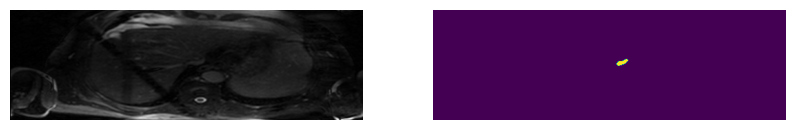

In [69]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(example_im_ax, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(example_label_ax)


image shape torch.Size([512, 512, 1]) label shape torch.Size([512, 512, 1])


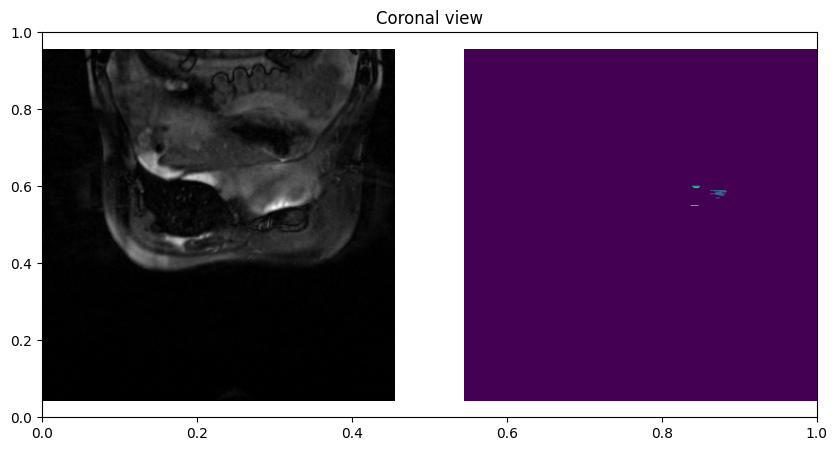

In [71]:
middle_image = check_data["img"][0, :, :, :, 30].T
middle_label = check_data["seg"][0, :, :, :, 30].T

print("image shape", middle_image.shape, "label shape", middle_label.shape)

plt.figure(figsize=(10, 5))
plt.title("Coronal view")
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(middle_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(middle_label)

image shape torch.Size([160, 512, 1]) label shape torch.Size([160, 512, 1])


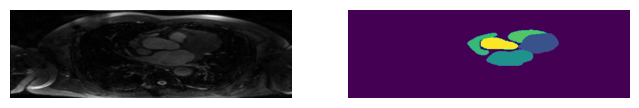

In [33]:
middle_image = check_data["img"][0, :, :, 250, :].T
middle_label = check_data["seg"][0, :, :, 250, :].T

print("image shape", middle_image.shape, "label shape", middle_label.shape)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(middle_image, cmap="gray")
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(middle_label)